# Polymer Machine Learning Foundation (1/4)
----

This notebook introduces end-to-end project of applying a machine learning (ML) workflow to a polymer informatic dataset to address a research problem.

## Python Packages

In [1]:
# Basic python packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
import time
from collections import Counter
import pickle
import collections
import seaborn as sns
import random

# RDKit related packaged
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# Scikit learn packages
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Tensorflow packages
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dense, Flatten, Activation

from rdkit import rdBase
rdBase.DisableLog('rdApp.warning')

## Background

### Glass transition temperature

The glass transition temperature ($T_g$) is the temperature when an amorphous material changes from a rigid, glassy solid to a soft, rubbery solid. 

**Physical meaning**  
* Below $T_g$
  - polymer chains frozen in place
  - only atomic vibrations
  - brittle behaviour
  - elastic modulus high
* Above $T_g$
  - chain segments rotate and rearrange
  - material becomes flexible
  - viscoelastic behavior

### Glass transition temperature dataset

The $T_g$ data used here come from the [Polyinfo](https://polymer.nims.go.jp) dataset, a curated collection of polymer material properties extracted from scientific literature. Access requires registering your email domain with datbase. For, this project I have placed the datasets under the folder `data`.

### Data inspection

Before modeling, we first examine the dataset to understand what each column represents and how information can be used effectively.

### Import the dataset
In the doe, objects ending with `_df` refere to pandas DataFrames.
    

In [2]:
# Read in the Tg data

Tg_df = pd.read_csv("../data/Tg.csv")
Tg_df.head()

,Smiles,Tg(C)
0,*C*,-63.48
1,*C(C*)C,-2.73
2,*C(C*)CC,-22.54
3,*C(C*)CCC,-32.29
4,*C(C*)C(C)C,10.97


In [3]:
### Analyse Data
display(Tg_df.info())
print(f"Shape of the dataset: {Tg_df.shape}")

<class 'pandas.DataFrame'>
RangeIndex: 6906 entries, 0 to 6905
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Smiles  6906 non-null   str    
 1   Tg(C)   6906 non-null   float64
dtypes: float64(1), str(1)
memory usage: 108.0 KB


None

Shape of the dataset: (6906, 2)


### Check for missing values

In [4]:
print("__NaN__")
Tg_df.isnull().sum()

__NaN__


Smiles    0
Tg(C)     0
dtype: int64

### Distribution of $T_g$

Text(0, 0.5, 'Density')

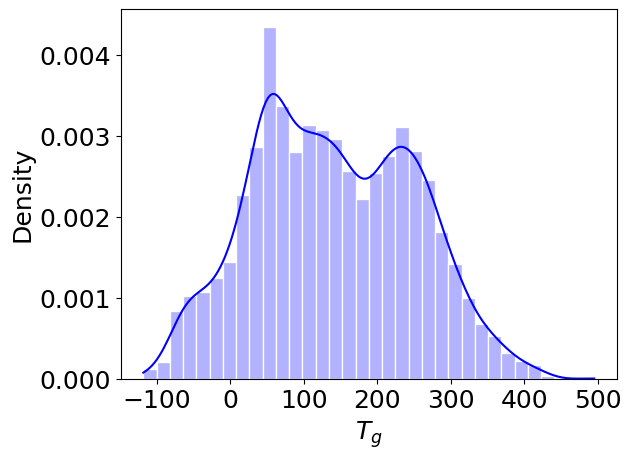

In [5]:
sns.histplot(Tg_df["Tg(C)"].dropna(), 
             kde=True, # smooth the distribution
             color="blue",
             stat="density",
             alpha=0.3,
             edgecolor="white"
            )
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("$T_g$", fontsize=18)
plt.ylabel("Density", fontsize=18)

In [6]:
Tg_df.describe()

,Tg(C)
count,6906.000000
mean,140.887194
std,109.162733
min,-118.000000
25%,55.600000
50%,134.000000
75%,229.127500
max,495.000000


### Visualize some SMILES

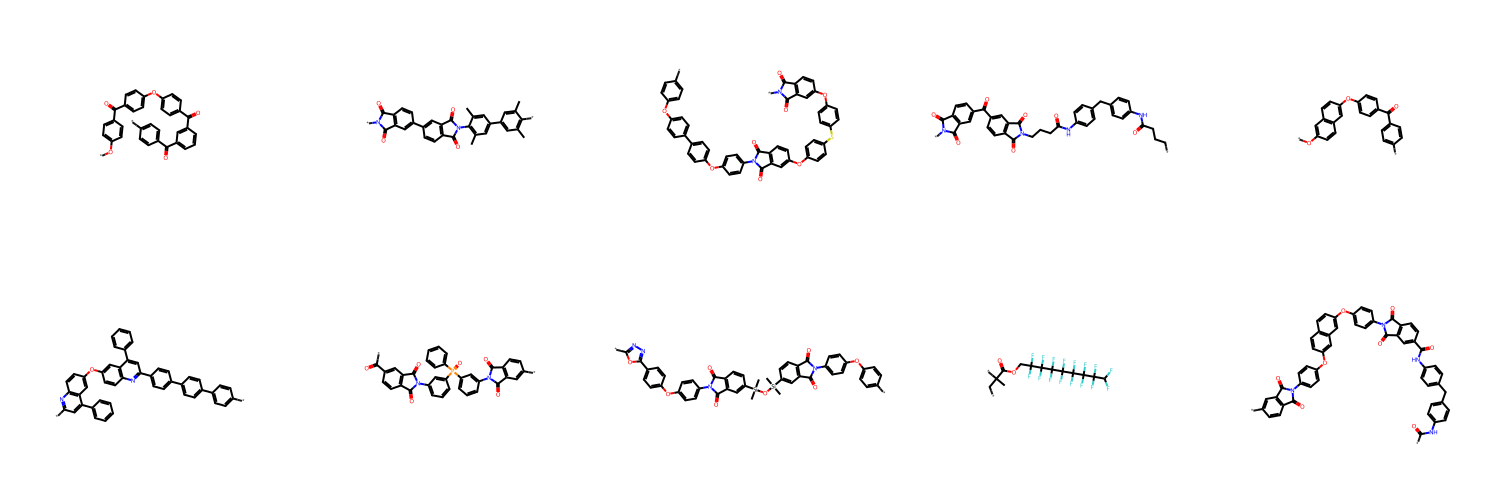

In [7]:
np.random.seed(42)

random_smiles = np.random.randint(0, len(Tg_df), 10)

# extract smiles
smiles_list = Tg_df.loc[random_smiles, "Smiles"].tolist()

# Convert to molecules
mols = [Chem.MolFromSmiles(mol) for mol in smiles_list]


# draw grid
img = Draw.MolsToGridImage(
    mols,
    molsPerRow=5,
    subImgSize=(300, 250),
)
img

### Feature Engineering

The goal of any feature engineering is to identify sturctural features that strongly correlate with the properties of the polymer. Feature engineering is the process of using domain knowledge to select, modify, or create new features from raw data to increase the the predictive power of machine learning algorithms. 

### Generation of Morgan fingerprint

Molecular fingerprints are vectors that represent the presence or absence of substructure within a molecule. These vectors are essential for comparing molecules and building preidictive models.

A widely used fingerprint in the community of cheminformatics is Morgan fingerprint, which is based on the analysis of the neighborhood of atoms within a molecule. 

In [8]:
from rdkit import DataStructs
radius = 3
nBits = 1024

def smiles_to_morgan_bits(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    arr = np.zeros((nBits, ), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

fp_series = Tg_df["Smiles"].apply(smiles_to_morgan_bits)

In [9]:
fps = np.vstack(fp_series)

fp_columns = [f"Bit_{i+1}" for i in range(nBits)]
fp_df = pd.DataFrame(fps, columns=fp_columns)

fp_df.head()

,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,Bit_10,...,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023,Bit_1024
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


View the substructure represented by each bit of the Morgan Fingerprint

Row 1 contains bit 1 | SMILES: *C(C*)C


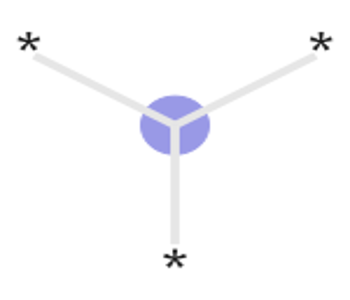

In [10]:
def show_morgan_bit_examples(
    df,
    bit_id: int,
    radius: int=3,
    nBits: int=1024,
    max_examples: int=1,
    smiles_col: str = "Smiles",
):
    """
    The goal is to find whose Morgan Fingerprint contains "bit_id" and visualize the atom environments. 
    """
    max_rows = len(df)
    found = 0

    for i in range(max_rows):
        smiles = df.iloc[i]["Smiles"]
        mol = Chem.MolFromSmiles(smiles)

        if mol is None:
            continue
        bitInfo = {}
        _ = rdMolDescriptors.GetMorganFingerprintAsBitVect(
            mol, radius, nBits=nBits, bitInfo = bitInfo
        )
        if bit_id not in bitInfo:
            continue
        # Visualize the first molecule that contains this bit
        img = Draw.DrawMorganBit(mol, bit_id, bitInfo, useSVG=False)

        try:
            img = img.resize(size=(350, 300))
        except Exception:
            pass
        
        print(f"Row {i} contains bit {bit_id} | SMILES: {smiles}")
        display(img)

        found += 1
        if found >= max_examples:
            return

show_morgan_bit_examples(Tg_df, bit_id=1, radius=3, nBits=1024, max_examples=1)
        


The central atom of the substructures is higlihted in purple, aromatic atoms are higligtes in yello, other atoms and bods are higlighted in gray.

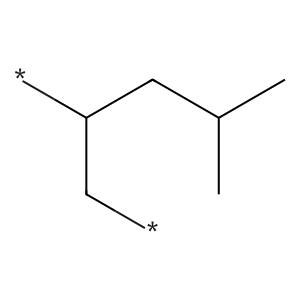

In [11]:
smiles = Tg_df["Smiles"][6]
molecule = Chem.MolFromSmiles(smiles)
Draw.MolToImage(molecule)

**Morgan figerprint with frequency**


Morgan fingerprint with frequency not only identifies the presence of specific molecular features within the fingerprint but also encodes the freqeuncy of these features, thereby enhancing the representation of polymer sturctures.

In [12]:
# Count all the substructure information

# Convert SMILES string to RDkit molecule objects. 
mols = Tg_df["Smiles"].apply(Chem.MolFromSmiles)

# Get Morgan fingerprints for each molecule with a radius of 3
fp = mols.apply(lambda m: AllChem.GetMorganFingerprint(m, radius=3))

# Get the non-zero elements from the fingerprints (i.e., the bits that are set)
fp_n = fp.apply(lambda m: m.GetNonzeroElements())

# Initialize an empty list to store the hash codes
HashCode = []
count = 0
for i in fp_n:
    for j in i.keys():
        HashCode.append(j)

# Get unique has codes and covert them into a list
unique_set = set(HashCode)
unique_list = list(unique_set)

# Create a Datafrm to map unique has codes to their indices
Corr_df = pd.DataFrame(unique_list).reset_index()

# Initialize an empty list to store the fingerprint vectors
Finger = []
for polymer in fp_n: 
    finger = [0] * len(unique_list)
    for keys in polymer.keys():
        index = Corr_df[Corr_df[0] == keys]["index"].values[0]
        finger[index] = polymer[keys]
    Finger.append(finger)

# convert the list of fingerprint vectors into a dataframe
Finger_df = pd.DataFrame(Finger)
Finger_df.head()

,0,1,2,3,4,5,6,7,8,9,...,26281,26282,26283,26284,26285,26286,26287,26288,26289,26290
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# filter input into the most polular X substurctures

# Count the number of zeros in each column of the DataFrame
zero_per_column = (Finger_df == 0).sum(axis=0)
nonzero_per_column = (Finger_df != 0).sum(axis=0)

print(zero_per_column)
print(nonzero_per_column)

0        6902
1        6905
2        6905
3        6905
4        6905
         ... 
26286    6645
26287    6897
26288    6874
26289    6905
26290    6905
Length: 26291, dtype: int64
0          4
1          1
2          1
3          1
4          1
        ... 
26286    261
26287      9
26288     32
26289      1
26290      1
Length: 26291, dtype: int64


In [14]:
zero_per_row = (Finger_df == 0).sum(axis=1)
nonzero_per_row = (Finger_df != 0).sum(axis=1)
print(zero_per_row)
print(nonzero_per_row)

0       26287
1       26281
2       26278
3       26275
4       26278
        ...  
6901    26257
6902    26250
6903    26253
6904    26198
6905    26195
Length: 6906, dtype: int64
0        4
1       10
2       13
3       16
4       13
        ..
6901    34
6902    41
6903    38
6904    93
6905    96
Length: 6906, dtype: int64


In [15]:
# Save the generated information

pickle_out = open("../data/Corr_All.pickle", "wb")
pickle.dump(Corr_df, pickle_out)
pickle_out.close()

### Descriptors

Descriptors represent another popular method for feature representation in the fields of ML and polymer informatics. These are quantifiable attributes or features of a molecule that can be calculated using various chemical and physical properties. Descriptors provide a way to numerically represent the characteristic of molecules in a format that ML models can efficiently process:

In [16]:
def calculated_all_descriptors(smiles):
    """
    Calculate all molecular descriptors for a molecule give its SMILES represenation. 

    Parameters:
    smiles (str): The SMILES string representing the molecule

    Returns:
    dict: A dictionary containg all the calculated molecular descriptors. Returns None if the molecule cannot be generated.
    """

    # Generate a molecule object from the SMILES string
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # If the molecule object is successfully created, calculated molecular descriptors
        descriptors = {}
        # Iterate over all molecular descriptor functions
        for descriptor_name, descriptor_function in Descriptors.descList:
            try:
                descriptors[descriptor_name] = descriptor_function(mol)
            except:
                descriptors[descriptor_name] = None
                
        return descriptors
    else:
        return None

# Smiles -> Mol -> Descriptors
descriptors_list = Tg_df["Smiles"].apply(lambda x: calculated_all_descriptors(x))

# Converst the list of descriptor dictionaries into a DataFrame where each row represent the descriptors for a molecule
descriptors_df = pd.DataFrame(descriptors_list.tolist())

# Display the resulting DataFrame with molecular descriptors
print(descriptors_df.head())

   MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0           1.750000        1.750000           0.875000        0.875000   
1           2.395833        2.395833           0.750000        0.750000   
2           2.332824        2.332824           0.743056        0.743056   
3           2.310000        2.310000           0.734306        0.734306   
4           2.374491        2.374491           0.699074        0.699074   

        qed        SPS   MolWt  HeavyAtomMolWt  ExactMolWt  \
0  0.355446  20.000000  14.027          12.011    14.01565   
1  0.414720  25.666667  42.081          36.033    42.04695   
2  0.451401  22.250000  56.108          48.044    56.06260   
3  0.476641  20.200000  70.135          60.055    70.07825   
4  0.465496  21.400000  70.135          60.055    70.07825   

   NumValenceElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0                    6  ...           0             0           0   
1                   18  ...           

**Remove constant columnt**

Columns that have a constant value for all data points have no information and cant possibly help the ML model learn anything. 

In [17]:
# Remove constant columns 
mask = (descriptors_df != descriptors_df.iloc[0]).any(axis=0)
descriptors_df_nonconstant = descriptors_df.loc[:, mask]
descriptors_df_nonconstant

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.750000,1.750000,0.875000,0.875000,0.355446,20.000000,14.027,12.011,14.015650,6,...,0,0,0,0,0,0,0,0,0,0
1,2.395833,2.395833,0.750000,0.750000,0.414720,25.666667,42.081,36.033,42.046950,18,...,0,0,0,0,0,0,0,0,0,0
2,2.332824,2.332824,0.743056,0.743056,0.451401,22.250000,56.108,48.044,56.062600,24,...,0,0,0,0,0,0,0,0,0,0
3,2.310000,2.310000,0.734306,0.734306,0.476641,20.200000,70.135,60.055,70.078250,30,...,0,0,0,0,0,0,0,0,0,0
4,2.374491,2.374491,0.699074,0.699074,0.465496,21.400000,70.135,60.055,70.078250,30,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6901,14.230116,14.230116,1.115390,-5.853856,0.764710,44.411765,270.119,264.071,270.029091,100,...,0,0,0,0,0,0,0,0,0,0
6902,14.610956,14.610956,0.457778,-6.005614,0.762588,33.809524,330.190,319.102,330.066619,124,...,0,0,0,0,0,0,0,0,0,0
6903,14.547685,14.547685,0.782397,-6.107007,0.783068,34.900000,316.163,307.091,316.050969,118,...,0,0,0,0,0,0,0,0,0,0
6904,6.761067,6.761067,0.026076,-0.514062,0.096597,23.661538,855.179,792.683,854.481129,328,...,0,0,0,0,0,0,0,0,6,0


In [18]:
# drop if there is any missing values
descriptors_df_nonconstant = descriptors_df_nonconstant.dropna(axis=1)

**Remove highly correlated features**

Features that are extremely similar don't give any additional information beyond the first appearance. They can alos confuse the model by giving very similar information that may essentially overload the model. Before we remove features, let's calculat the correlation matrix for all the features.

In [19]:
# Remove highly correlated features
descriptors_corr_df = descriptors_df_nonconstant.corr(method="pearson").abs()

**Visualization**

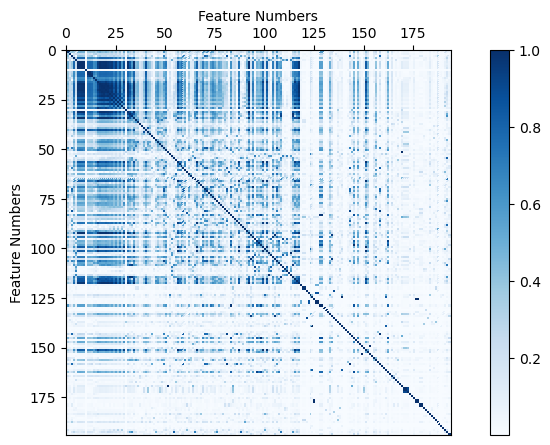

In [20]:
fig1, ax1 = plt.subplots(figsize=(10, 5))
c = ax1.pcolor(descriptors_corr_df, cmap="Blues")
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Feature Numbers')
ax1.set_ylabel('Feature Numbers')
ax1.set_aspect('equal')
plt.colorbar(c,ax=ax1)
plt.show()

In [21]:
threshold = 0.95

# take absolute correlation
corr = descriptors_corr_df.abs()

# keep only upper triangle (avoid duplicates)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# find columns to drop
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# filtered dataframe
descriptors_df_filtered = descriptors_df_nonconstant.drop(columns=to_drop)

# recalculate the correlation matrix
descriptors_corr_df_filtered =  descriptors_df_filtered.corr(method="pearson").abs()

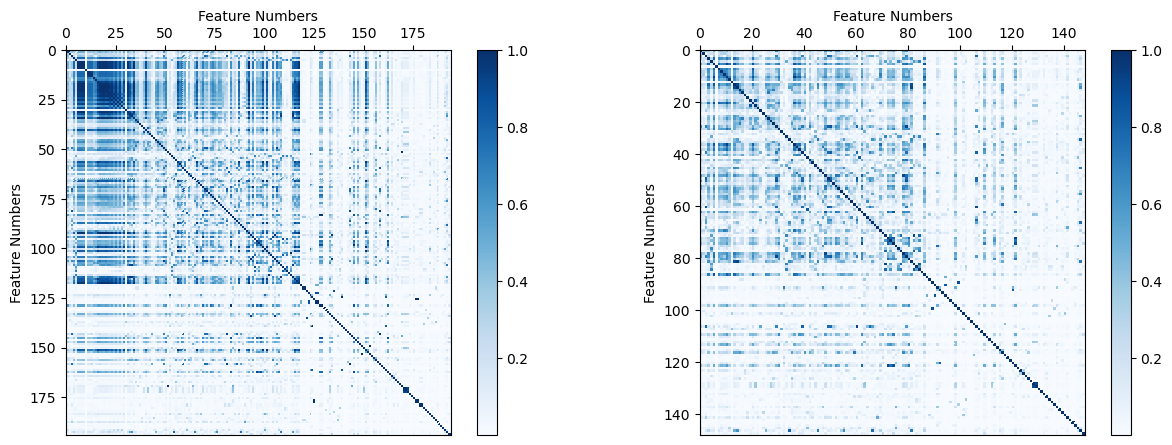

In [22]:
# plot correlation after removing highly correlated features

fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
c1 = ax1.pcolor(descriptors_corr_df,cmap="Blues")
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Feature Numbers')
ax1.set_ylabel('Feature Numbers')
ax1.set_aspect('equal')

plt.colorbar(c1,ax=ax1)

c2 = ax2.pcolor(descriptors_corr_df_filtered, cmap="Blues")
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Feature Numbers')
ax2.set_ylabel('Feature Numbers')
ax2.set_aspect('equal')
plt.colorbar(c2,ax=ax2)
plt.show()

**Feature Normalization**

It should be fairly apparent that our features come in many shapes and sizes. ML algorithms can be very sensitive to these difference. For example one feature may be several orders of magnitude larger in values and in range of values. This can make some algorithms significantly biased towards those features so the best practice is usually to perform some alteratin to make all the feature look similar, while still preserving the information they contain.

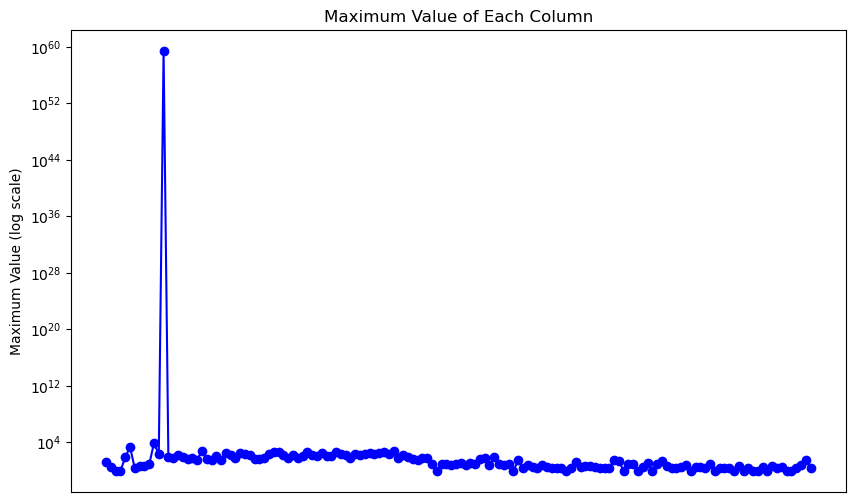

In [23]:
max_values = descriptors_df_filtered.max()

plt.figure(figsize=(10, 6))
plt.plot(max_values, marker="o", ls="-", color="b")
plt.yscale('log')

plt.title('Maximum Value of Each Column')
plt.ylabel('Maximum Value (log scale)')

plt.xticks([])

plt.show()

It is clear that some values for some features are way higher than others. 

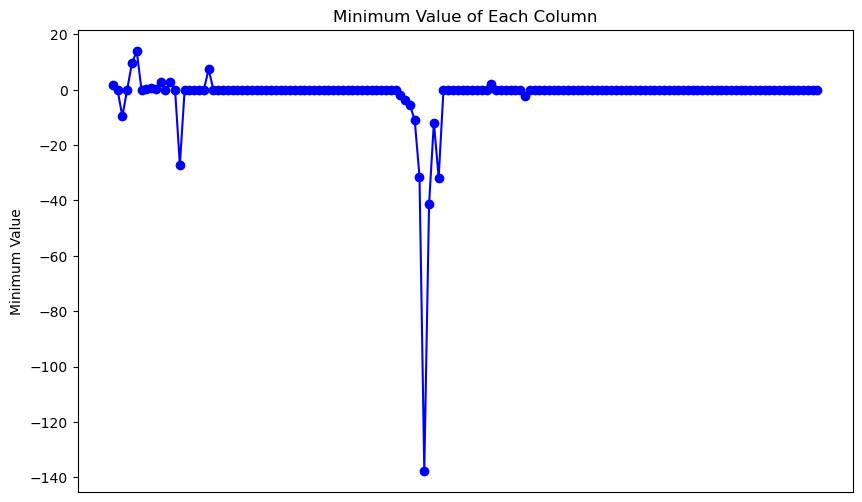

In [24]:
min_values = descriptors_df_filtered.min()

plt.figure(figsize=(10, 6))
plt.plot(min_values, marker="o", ls="-", color="b")
#plt.yscale('log')

plt.title('Minimum Value of Each Column')
plt.ylabel('Minimum Value')

plt.xticks([])

plt.show()

In [25]:
# Apply Min-Max scaling to normalize the descriptors data
# MinMaxScaler scales the features to a range between 0 and 1
minmax_descriptors = MinMaxScaler().fit_transform(descriptors_df_filtered)
# Convert the normalized descriptors back into a DataFrame
# The column names are preserved from the original DataFrame
minmax_descriptors_df = pd.DataFrame(minmax_descriptors, columns=descriptors_df_filtered.columns)
print(minmax_descriptors_df.shape)

(6906, 148)


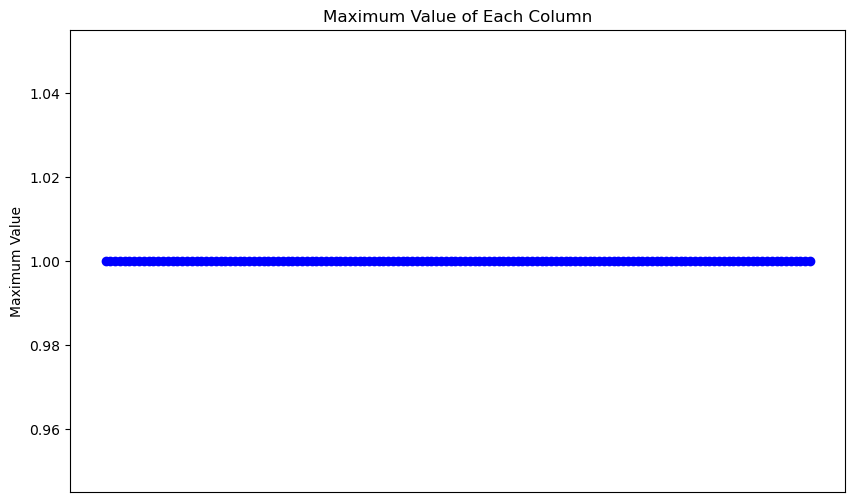

In [26]:
max_values = minmax_descriptors_df.max()

plt.figure(figsize=(10, 6))
plt.plot(max_values, marker="o", ls="-", color="b")


plt.title('Maximum Value of Each Column')
plt.ylabel('Maximum Value')

plt.xticks([])

plt.show()

In [27]:
# Let's save the file, so that we can use in the notebook 02_polymer_property_prediction.

minmax_descriptors_df.to_pickle("../data/foundation.pickle")

In [28]:
descriptors_df_nonconstant.columns()

AttributeError: 'DataFrame' object has no attribute 'col'